In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from pylab import show, figure
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()


In [2]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

# The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.
# The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the
# input function (PCTL in this case) to take one argument (S1). Then, if the input function normally 
# takes more than one argument the 'extra_arguments' variable needs to be defined as a tuple 
# (hence (3,) instead of (3)).
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = (2 * (D*(H**2) + E*(G**2) - (F*G*H))) / (G**2 + H**2)
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def difference_from_mean_elevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y


In [3]:
input_DEM_resolution = 1
location = (r'C:/PhD/junk')
os.chdir(location)
input_geotiff = gdal.Open('fann_2013_1m0.tif')
ig = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
#input_DEM = scipy.ndimage.zoom(x, input_DEM_resolution / initial_resolution, order = 1)
input_DEM = ig
gully_head_layer = gdal.Open('fann_0_gh.tif')
gh = np.array(gully_head_layer.GetRasterBand(1).ReadAsArray())
# This is only required because ArcGIS produced the original grid with 1 as background and 0 as points.
gully_heads = (gh - 1)**2 

In [4]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [5]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape));

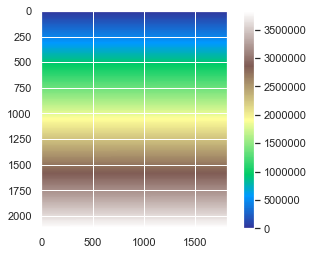

In [6]:
plt.imshow(grid_nodes, cmap="terrain");
plt.colorbar();

## Isolate all gully head nodes

In [7]:
find_nodes = np.multiply(gully_heads, grid_nodes);

## Create array of only gully head nodes 

In [8]:
gh_array = np.unique(find_nodes);

## Turn gully head node array into a list and remove the value 0

In [9]:
gh_list = gh_array.tolist();
gh_list.remove(0);

## Work through list finding index positions of each node

In [274]:
current_node = gh_list[12];

In [275]:
current_node

2674967

In [276]:
result = np.where(grid_nodes == current_node)

In [299]:
row_index = result[0][0];
col_index = result[1][0];

In [301]:
col_index

935

In [255]:
row_index = 20
col_index = 18

In [229]:
x = np.random.randint(10, size=(21,21))

In [239]:
x

array([[8, 2, 2, 5, 6, 9, 9, 6, 1, 7, 6, 5, 2, 2, 0, 9, 4, 4, 3, 4, 7],
       [6, 7, 5, 0, 5, 0, 4, 9, 2, 3, 3, 0, 3, 8, 9, 3, 5, 8, 9, 3, 4],
       [8, 7, 7, 8, 5, 4, 4, 8, 6, 6, 2, 3, 2, 5, 6, 3, 5, 8, 5, 9, 9],
       [8, 1, 5, 6, 5, 5, 6, 3, 7, 6, 4, 0, 8, 4, 1, 2, 5, 9, 1, 9, 5],
       [2, 3, 5, 6, 5, 2, 1, 5, 2, 7, 0, 4, 2, 3, 8, 1, 7, 6, 7, 5, 5],
       [9, 1, 3, 0, 6, 5, 9, 7, 3, 3, 7, 1, 4, 5, 7, 8, 0, 7, 9, 5, 7],
       [7, 6, 6, 0, 9, 2, 3, 7, 8, 2, 0, 4, 4, 7, 0, 4, 6, 1, 5, 3, 4],
       [6, 3, 4, 3, 9, 2, 5, 7, 2, 2, 7, 7, 5, 1, 8, 9, 7, 0, 5, 0, 7],
       [0, 5, 1, 7, 1, 5, 5, 8, 9, 3, 9, 8, 9, 7, 4, 0, 6, 0, 2, 4, 7],
       [3, 8, 0, 8, 6, 5, 9, 2, 6, 3, 3, 6, 2, 2, 0, 8, 5, 3, 1, 2, 5],
       [6, 4, 7, 3, 5, 2, 1, 0, 8, 7, 5, 4, 5, 0, 9, 6, 4, 3, 7, 9, 0],
       [8, 3, 5, 7, 1, 5, 3, 0, 2, 3, 4, 6, 2, 4, 2, 3, 2, 8, 1, 5, 3],
       [8, 3, 1, 5, 8, 1, 1, 5, 3, 2, 5, 9, 1, 0, 1, 1, 4, 9, 9, 3, 9],
       [8, 4, 0, 1, 7, 7, 4, 6, 3, 6, 7, 4, 7, 0, 3, 6, 4, 9, 9,

In [256]:
x[20,18]

9

In [257]:
distance_from_node = 10

In [258]:
subset_row_top = int(row_index - distance_from_node)
subset_row_bot = int(row_index + distance_from_node) + 1
subset_col_left = int(col_index - distance_from_node)
subset_col_right = int(col_index + distance_from_node) + 1

In [259]:
print(subset_row_top, ' ', subset_row_bot);
print(subset_col_left, ' ', subset_col_right);

10   31
8   29


In [260]:
subset_row_top_adjusted = max(subset_row_top, 0);
subset_row_bot_adjusted = min(subset_row_bot, x.shape[0]);
subset_col_left_adjusted = max(subset_col_left, 0);
subset_col_right_adjusted = min(subset_col_right, x.shape[1]);

In [261]:
print(subset_row_top_adjusted, ' ', subset_row_bot_adjusted);
print(subset_col_left_adjusted, ' ', subset_col_right_adjusted);

10   21
8   21


then i need to know by hpow much the output was adjusted and the target grid node can be found by adjusting for that offset.

In [262]:
offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));

In [263]:
print(offset_row_top, offset_row_bot)
print(offset_col_left, offset_col_right)

0 10
0 8


In [264]:
x_copy = np.copy(x);
x_subset = x_copy[subset_row_top_adjusted:subset_row_bot_adjusted, subset_col_left_adjusted:subset_col_right_adjusted];

In [265]:
x_subset

array([[8, 7, 5, 4, 5, 0, 9, 6, 4, 3, 7, 9, 0],
       [2, 3, 4, 6, 2, 4, 2, 3, 2, 8, 1, 5, 3],
       [3, 2, 5, 9, 1, 0, 1, 1, 4, 9, 9, 3, 9],
       [3, 6, 7, 4, 7, 0, 3, 6, 4, 9, 9, 7, 9],
       [7, 3, 2, 2, 2, 9, 3, 5, 3, 8, 9, 4, 4],
       [4, 3, 3, 9, 7, 8, 1, 1, 7, 7, 0, 9, 0],
       [7, 6, 8, 8, 7, 5, 2, 1, 2, 8, 9, 2, 2],
       [4, 4, 3, 6, 8, 1, 6, 0, 2, 3, 5, 3, 6],
       [5, 7, 3, 6, 2, 7, 6, 6, 8, 3, 0, 7, 2],
       [4, 2, 6, 3, 2, 8, 0, 4, 1, 9, 8, 9, 5],
       [8, 6, 3, 5, 2, 9, 5, 6, 7, 9, 9, 6, 2]])

In [266]:
int_node_lat = distance_from_node + offset_row_top
int_node_lon = distance_from_node + offset_col_left

In [267]:
print(int_node_lat, int_node_lon)

10 10


if i leave offset signed then I can just add it

In [254]:
central_node

NameError: name 'central_node' is not defined

## Choose a width (and heigth) for the subset DEM. Must be even number.

In [278]:
wh = 20

## Create a subset of the DEM centered on the gully head. Row bottm index and col right index both have 1 added so that the gully head point remains as the single central grid cell of the subset DEM, located exactly in the centre.

In [38]:
input_DEM.shape

(2120, 1808)

In [279]:
subset_row_top = int(row_index - (wh/2))
subset_row_bot = int(row_index + (wh/2)) + 1
subset_col_right = int(col_index + (wh/2)) + 1
subset_col_left = int(col_index - (wh/2))

In [280]:
print(subset_row_top, ' ', subset_row_bot);
print(subset_col_left, ' ', subset_col_right);

1469   1490
925   946


In [281]:
dem_subset_copy = np.copy(input_DEM);
dem_subset = dem_subset_copy[subset_row_top:subset_row_bot, subset_col_left:subset_col_right];

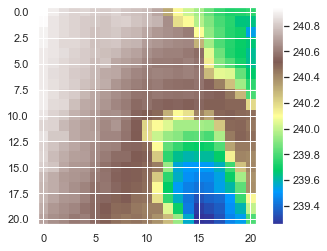

In [282]:
plt.imshow(dem_subset, cmap="terrain");
plt.colorbar();

In [283]:
flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
#################################################################################################
rows_sub = flow_acc_surf_sub.shape[0];
cols_sub = flow_acc_surf_sub.shape[1];
mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

In [284]:
sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg1,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
#(flow_acc, q) = fa.accumulate_flow();
fa.run_one_step()
fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
fd.run_one_step()

In [285]:
da = np.array(mg1.at_node['drainage_area'].round(4));
frn = mg1.at_node['flow__receiver_node'];
drainage_area = da.reshape(mg1.shape);
wuf = np.array(mg1.at_node['water__unit_flux_in']);
frp = np.array(mg1.at_node['flow__receiver_proportions']);
funo = np.array(mg1.at_node['flow__upstream_node_order'].reshape(mg1.shape));
ns = np.flip(mg1.status_at_node.reshape(mg1.shape), 0);
flow_rec_surf_rows = cols_sub * rows_sub;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
flrn = mg1.at_node['flow__link_to_receiver_node'];
links_carrying_flow = flrn.reshape(flow_rec_surf_rows,8);
tss = mg1.at_node['topographic__steepest_slope'];
steepest_slope = tss.reshape(flow_rec_surf_rows,8);
all_receiver_proportions = np.copy(frp);
grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));


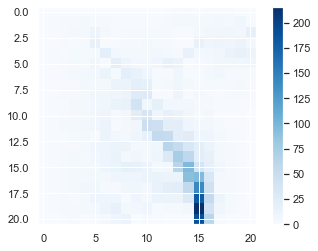

In [286]:
plt.imshow(drainage_area, cmap="Blues");
plt.colorbar();

Still need a way to start i.e. look at 9 grid cell window around startining gh and find the largesat value and start from there.

Maybe here I can just map the node value from the larger DEM to the subset and back again at the end?

I know how much it's off in any direction and so then I know where the gh node is.

In [287]:
central_node = int(dem_subset.shape[0]**2/2) # Could also be shape[1] because it's always a square.



In [298]:
# Specific the size of the area to be checked. This represents a physical distance from the 
# outlet but has no unit of measure.
distance_from_outlet = 10
# This value is used to initialise the search.
catchment_outlet_id = central_node
catchment_area_dict = {}
# Initate an outer loop that iterates through every distance interval from the outlet.
contributing_fraction = 0.95
node_location = mg1.nodes.reshape(da.shape);
for i in range(0, distance_from_outlet):
    print('distance: ', i)
    # Create a list initially containing only the outlet grid cell.
    if i == 0:
        candidate_gridcell = catchment_outlet_id;
    else:
        candidate_gridcell = next_cell_downstream;
    print(candidate_gridcell)

    grid_cell_receiver_nodes = frp[candidate_gridcell,:];
    if np.amax(grid_cell_receiver_nodes) < contributing_fraction:
        if i == 9:
            print('no grid cell found')
        else:
            print(np.amax(grid_cell_receiver_nodes))
            index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];

            next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            print('next cell ', next_cell_downstream)
    else:
        print(candidate_gridcell)
        
        #catchment_area_dict[candidate_gridcell] = 
        break

#CountryCodeDict["Spain"]= 34
                    

distance:  0
220
0.491339847692
next cell  241
distance:  1
241
0.550159456361
next cell  263
distance:  2
263
0.608320376515
next cell  285
distance:  3
285
0.486104363322
next cell  307
distance:  4
307
0.426070710037
next cell  329
distance:  5
329
0.56053082177
next cell  351
distance:  6
351
0.59525132632
next cell  372
distance:  7
372
0.740825124109
next cell  393
distance:  8
393
0.906204683589
next cell  414
distance:  9
414
no grid cell found


In [290]:
drainage_area.shape

(21, 21)

In [291]:
21*21

441